# Week #5 - The Pseudospectral method  and function interpolation

> Apparently it is related to the use of Fourier series to solve the wave equation.
Furthermore, as an interpolation scheme one uses the Chebyshev polynomials.

## Function interpolation - trigonometric basis functions

We have discussed few ways to improve the accuracy of our numerical methods.
One of them were to increase the accuracy by simply shortening the distance
(in space or time). Another way was to take a higher order derivative operator,
*e.g.*, a five-point operator. A question which arises is: *Can we do better
than that?* A way of doing so is by a Fourier transform (which is a transform
method). To do so, we will need to gather the knowledge about function interpolation
and exact interpolation on discrete regular grids.That is important for different
known methods like the Garlekin-type methods and also finite difference methods.

This function interpolation is useful (and used) because some physical quantities
change abruptly, but since we are dealing with PDE we would be interested in using
smooth functions which can be differentiated. For instance, supporse that one has
a function $f(x)$, which can be approximated by a function $g_\mathrm{N}(x)$

$$
    f(x) \simeq g_\mathrm{N}(x) = \sum_{i=0}^{N}a_i\phi_i(x)\,.
$$
The coefficients $a_i$ are the weights/components and $\phi_i$ are the basis
functions. Now the question is crystal clear: *What basis functions should we use?
What are the coefficients?*
Since these basis functions are known analitically, their derivatives are known as well.

Whether one considers a basis functions composed by sines and cosines, $f(x)$ is given by

$$
    f(x) \simeq g_\mathrm{N}(x) = \frac{1}{2}a_0 + \sum_{k=1}^N \left[a_k\cos(kx) + b_k\sin(kx)\right]\,.
$$
The coefficients are obtained by minimizing the norm of the difference, *i.e.*, $||f(x)-g_\mathrm{N}||$. The norm is given by

$$
||f(x)-g_\mathrm{N}||\equiv \left\{\int_a^b\mathrm{d}x \left[f(x) - g_\mathrm{N}(x)\right]^2\right\}^{1/2}
$$


>> Example/exercise of Fourier decomposition for the function $x^2$

The result is

$$
    x^2 = \frac{4\pi^2}{3} + \sum_{k=1}^\infty\left[\frac{4}{k^2}\cos(kx) -\frac{4\pi}{k}\sin(kx)\right]\,.
$$

Let's verify this approximation numerically

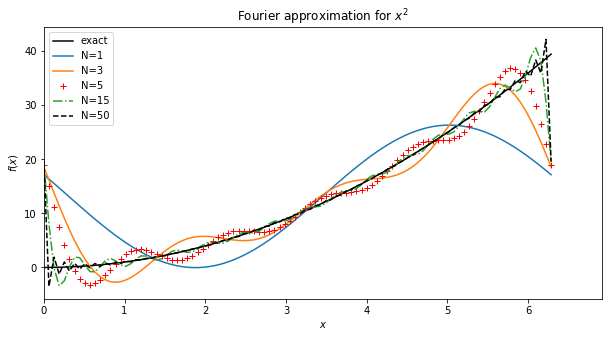

In [62]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,100)
x2 = x**2
y = np.zeros(len(x))

def gn_k(x,k):
    return 4*np.cos(k*x)/k**2 -4*np.pi*np.sin(k*x)/k
    
def gn(x,N):
    y = np.zeros(len(x))
    for k in range(1,N+1):
        y = y + gn_k(x,k)
    return 4*np.pi**2/3 + y
    
fig, ax = plt.subplots(figsize = (10,5))
#line, = ax.plot(y)
ax.set_xlim(0,np.max(x)*1.1)
#ax.set_ylim(np.min(y)*1.1,np.max(y)*1.1)
ax.set_xlabel("$x$")
ax.set_ylabel('$f(x)$')
ax.set_title('Fourier approximation for $x^2$')

plt.plot(x,x**2, c = 'black', label = 'exact')
plt.plot(x,gn(x,1), label = 'N=1')
plt.plot(x,gn(x,3), label = 'N=3')
plt.plot(x,gn(x,5),'r+', label = 'N=5')
plt.plot(x,gn(x,15),'-.', label = 'N=15')
plt.plot(x,gn(x,50),'--', label = 'N=50', c='black')
plt.legend()


As we can observe, at the edges we are "overshooting" the function. This is a signature
of the Gibbs phenomenon which appears at the discontinuities${}^1$ and it cannot be avoided.
That is one of the reasons why generally one avoids discontinuity when wants to try
to employ these methods involving Fourier series.

${}^1$ *We have calculated the function for the interval $[0,2\pi]$. Consequently,
this function is going to be repeated and have a jump from zero to the maximum value,
which we estimate to be slightly bigger than $36$.*

## Discrete Fourier Series

Since in computer we need to work in a *discrete world* we need to know how to that
with the continuous quantity that we handle.Since now we are dealing with discrete
quantities, instead of having integrals to obtain the coeff, we have sums (the same
idea of inner product still holds).

An important point is observed: **the discrete approximation exactly interpolates
the function at the grid points.**  

To be answered? *Professor Igel mentions about the derivative being exact at the grid
points. However, if the function takes arbitrary values in between them, how could one
ensures that the derivative are the same?* Ahh okay, got it ,because the derivative will
be computed at the grid points themselves, of course that doesn't matter and the derivative
are the same.


Cardinal functions: apparently very relevant for Garlekin finite difference methods.

## The Fourier Transform - Derivative

Nothing new so far, essentially that $\partial_x^n \rightarrow ik$. But, remarkably, 
the derivative using these Fourier transform techniques are exact at the points
(regular grid *(is this condition necessary?))* and that is better than the finite
difference method. Ah okay, that's nice, the idea is to employ the fft methods to invert,
multiply by the factor $ik$ and comeback to real space.

In [104]:
import numpy as np
import matplotlib.pyplot as plt

nx = 1000
lmin = -np.pi
lmax = np.pi
dx = (lmax-lmin)/nx

x = np.linspace(lmin, lmax, nx)
f = np.cos(x)*np.exp(-x**2/4)                                       # function
df = -np.sin(x)*np.exp(-x**2/4) - np.cos(x)*np.exp(-x**2/4)*x/2   # exact derivative
df_fd = np.zeros(nx)                                                # numerical derivative by finite difference method

for j in range(0,nx-1):
    df_fd[j] = (f[j+1] - f[j])/dx

fhat = np.fft.fft(f)                                   # Fourier transform of f(x)
k = 2*np.pi/(lmax-lmin)*np.linspace(-nx/2,nx/2,nx)     # k vector
k = np.fft.fftshift(k)
#    We have to use the command above to shift the wavevector in a way to be compatible
# to what is done in the Fourier transform np.fft.fft(f). To do so, we need to use the shift command


dfhat = 1j*k*fhat                                      # Fourier transform of df/dx
df_fft = np.fft.ifft(dfhat)                            # inverse Fourier transform of dfhat
df_fft = np.real(df_fft)                               # to discount small imaginary part from numerical error


# Uncomment these lines to see the difference
#print (k)
#print (np.fft.fftshift(k))
#print (np.fft.fftshift(np.fft.fftshift(k)))

error_fd = 100*np.sqrt((df_fd - df)**2)/df           # error in the df/dx for the fd derivative compared to the exact one in %%
error_fft = 100*np.sqrt((df_fft - df)**2)/df         # error in the df/dx for the fft derivative compared to the exact one in %%

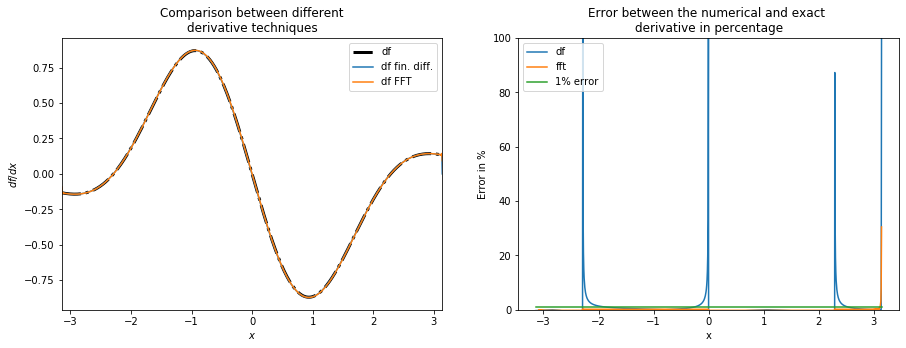

In [107]:
fig, (ax,ax_err) = plt.subplots(1,2,figsize = (15,5))

ax.set_xlabel('$x$')
ax.set_ylabel('$df/dx$')
ax.set_xlim(np.min(x),np.max(x))

#ax.plot(x,f, label = 'f')
ax.plot(x,df, label = 'df',ls='-.', c = 'black', lw = 3)
ax.plot(x,df_fd, label = 'df fin. diff.')
ax.plot(x,df_fft, label = 'df FFT')
ax.set_title('Comparison between different\nderivative techniques')
ax.legend()

ax_err.set_xlabel('x')
ax_err.set_ylabel('Error in %')
ax_err.set_ylim(0,100)
ax_err.plot(x,error_fd, label = 'df')
ax_err.plot(x,error_fft, label = 'fft')
ax_err.plot(x,np.zeros(nx)+1, label = '1% error')
ax_err.set_title('Error between the numerical and exact \nderivative in percentage')
ax_err.legend()

> The pseudo spectral method is very useful for studying anisotropic problems.
Since the method is isotropic, any kind of anisotropic effect is an entirely 
physical effect.

> Apparently the method is not very used for 3d problem due to the difficulties of
implementing it with parallelization.

## Convolution 

Convolution theorem says

$$
\mathcal{F}^{-1}[D(K)P(K)] = d(x)*p(x)
$$
multiplication in the spectral domain = convolution in the space domain.
When one considers the derivative, how does it look like in the spectral domain?
The main point regarding this question is because we have a finite space Fourier
space given by $2k_\text{max} = 2\pi/\mathrm{d}x$. Consequently, the derivative
in the spectral domain can be cast in the following form

$$
D(k) = ik\left[H(k+k_\text{max}) - H(k_\text{max})\right]
$$

inverting it, to the real space it is a combination of cardinal functions
(actually the derivative of Sinc(x)). That allows one to check the accuracy
of the operators in the spectral domain.

*Note: I think that I didn't fully get all the discussion. Might comeback
later to watch it again. I mean, I get the idea, but there was some parts
that was a bit foggy about the motivation to do so.*

## Chebyshev polynomials - Derivatives

We have worked so far, for computing derivatives, the trigonometric
functions or the Fourier method. Another way of doing essentially
the same thing is using different basis functions. One of the possible
and interesting choices is the Chebyshev polynomials.

The Chebyshev polynomials rely on the following trigonometric identities
to build up the polynomials

$$
    \cos[(n+1)\phi] + \cos[(n-1)\phi] = 2\cos\phi\cos(n\phi)\,.
$$

The trigonometric relation gives us polynomials in $\cos\phi$:

\begin{align}
    \cos(2\phi) &= 2\cos^2\phi -1\\
    \cos(3\phi) &= 4\cos^3\phi -3\cos\phi\\
                &\vdots
\end{align}

Making the following correspondence $\cos(n\phi) \equiv T_n(\cos\phi)
\equiv T_n(x)$, one has

\begin{align}
    T_0(x) &= 1\\
    T_1(x) &= x\\
    T_2(x) &= 2x^2 -1\\
           &\vdots
\end{align}
where, since $x = \cos\phi\rightarrow x\in [-1,1]$. This important fact
allows us to represent functions which are defined in a limited area.
The latter eases the process of encompassing boundary conditions 
in a problem.

To do so, we start by expanding a function in terms of the Chebyshev polynomials

$$
f(x) \simeq g_N(x) = \frac{1}{2}c_0T_0 + \sum_{k=0}^{N}c_kT_k\,.
$$

This is for the continuous world. What we want to do now is to turn it into
its discrete form, having the same interpolation properties that have
found previously for the Fourier representation.

The extremal values of the Chebyshev polynomials (that is, when the derivative
at those points are zero), are called the *Chebyshev collocation points* and
they are the points where one has exact interpolation. Taking the derivative
with respect to $\phi$ it is rather straightforward to check that these
extremal are given by

$$
x_k = \cos\frac{k\pi}{n}\,,
$$
which has values $x_k = \pm 1$. Now, let's take a look on them

In [27]:
import numpy as np
import matplotlib.pyplot as plt

#def t(n,phi):
#    return 2*np.cos((n-1)*phi)*np.cos(phi) - np.cos((n-2)*phi)

#Think about an easier way to make this plot
    
    
    

One of the maind differences are that when one increases the
order of the polynomials, the distance between them change.
Consequently, since those are the points where one has
perfectly match, the grids are not regular grids anymore.
*Apparently this has important consequences when one does
time dependent calculations*

For a smooth and continuous function, one sees a perfect match
between the Chebyshev collocation points and the function. However
when we consider a Heaviside function, which has a discontinuity, 
one observes a Gibbs phenomenon once more.

Similar to what we has for Fourier transform, we have an "algebraic
way" to obtain the derivative, instead of taking it in fact.

The derivative is given by the following 

## Playing around with the questions

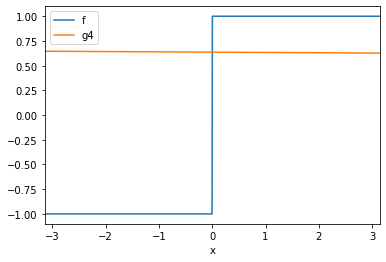

In [15]:
import numpy as np
import matplotlib.pyplot as plt

nx = 1000
lmin = -np.pi
lmax = np.pi
x = np.linspace(lmin, lmax, nx)

f = np.sign(x)

def g1(x,nmax):
    sumg = np.zeros(len(x))
    for k in range(1,nmax):
        sumg = np.cos(2*k)*x/(2*k)
    return np.pi/2 + (2/np.pi)*sumg

def g2(x,nmax):
    sumg = np.zeros(len(x))
    for k in range(nmax):
        sumg = np.sin(2*k+1)*x/(2*k+1)
    return (4/np.pi)*sumg

def g3(x,nmax):
    sumg = np.zeros(len(x))
    for k in range(1,nmax):
        sumg = np.sin(2*k)*x/(2*k)
    return (3/np.pi)*sumg

def g4(x,nmax):
    sumg = np.zeros(len(x))
    for k in range(nmax):
        sumg = np.cos(2*k+1)*x/(2*k+1)
    return 2/np.pi + (4/np.pi)*sumg



fig, ax = plt.subplots()
ax.set_xlim(-np.pi, np.pi)
ax.set_xlabel('x')
plt.plot(x,f, label= 'f')
#ax.plot(x,g1(x,100), label = 'g1')
#ax.plot(x,g2(x,100), label = 'g2')
#ax.plot(x,g3(x,100), label = 'g3')
ax.plot(x,g4(x,100), label = 'g4')

plt.legend()